In [1]:
import pandas as pd 
import polars as pl
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


combined_df = pd.read_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv')

/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def calculate_market_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Aggregate stock data into market-level features for each minute.
    
    Parameters:
    - df: Polars DataFrame containing stock data with necessary columns.
    
    Returns:
    - market_data: Polars DataFrame with aggregated market-level features.
    """
    market_data = (
        df.group_by('minute')
        .agg([
            # Price volatility (standard deviation of weighted trade prices)
            pl.col('weighted_trade_price').std().alias('price_volatility'),

            # Return volatility (volume-weighted standard deviation of returns)
            (
                (pl.col('return') * pl.col('total_trade_volume'))
                .sum()
                / pl.col('total_trade_volume').sum()
            ).alias('avg_return'),
            pl.col('return').std().alias('return_volatility'),

            

            # Trade volume statistics
            pl.col('total_trade_volume').mean().alias('avg_trade_volume'),
            pl.col('total_trade_volume').std().alias('volume_volatility'),

            # Average bid-ask spread
            ((pl.col('weighted_ask_price') - pl.col('weighted_bid_price')).mean())
            .alias('avg_spread'),

            # Proportion of advancing stocks (positive returns)
            (pl.col('return') > 0).mean().alias('advancing_stocks'),
        ])
        .fill_null(0)  # Replace null values with 0
    )

    # Ensure the results are sorted by minute
    market_data = market_data.sort('minute')

    return market_data

In [3]:
#prepare market features
combined_df = pl.DataFrame(combined_df)
market_data = calculate_market_data(combined_df)



In [4]:
market_data

minute,price_volatility,avg_return,return_volatility,avg_trade_volume,volume_volatility,avg_spread,advancing_stocks
str,f64,f64,f64,f64,f64,f64,f64
"""2010-05-03 09:30:00-04:00""",44.178432,0.004845,0.005309,397540.447619,2.9211e6,0.180964,0.627907
"""2010-05-03 09:31:00-04:00""",42.087616,0.00036,0.002905,147834.982906,894941.945331,0.116104,0.6
"""2010-05-03 09:32:00-04:00""",44.210426,-0.002906,0.00259,271919.94958,2.4171e6,0.077482,0.529915
"""2010-05-03 09:33:00-04:00""",43.771961,-0.004586,0.002798,210191.362903,1.9084e6,0.088461,0.596774
"""2010-05-03 09:34:00-04:00""",44.20407,-0.000179,0.001869,315054.5,3.0612e6,0.077935,0.5
…,…,…,…,…,…,…,…
"""2010-05-28 15:56:00-04:00""",30.515974,-0.002326,0.000879,66782.308943,194534.002545,0.02457,0.00813
"""2010-05-28 15:57:00-04:00""",36.84272,-0.001509,0.000694,123828.325397,513753.591724,0.031873,0.007937
"""2010-05-28 15:58:00-04:00""",30.250318,-0.001353,0.000703,90634.046875,299053.569279,0.022169,0.03125


In [5]:

def create_sparse_similarity_lazyframe(feature_df: pl.DataFrame, threshold: float = 0.5):
    """
    Create a sparse similarity matrix with optimization for large datasets.

    Parameters:
    - feature_df: Polars DataFrame containing the features.
    - threshold: Minimum similarity value to include in the sparse matrix.

    Returns:
    - LazyFrame with columns [row, col, similarity].
    """
    # Select features and handle NaNs
    clustering_features = [
        'price_volatility',
        'return_volatility',
        'avg_return',
        'avg_trade_volume',
        'volume_volatility',
        'advancing_stocks',
        'avg_spread'
    ]
    features = feature_df.select(clustering_features).to_numpy()
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Create a Polars DataFrame with scaled features
    scaled_df = pl.DataFrame(features_scaled, schema=clustering_features)

    # Generate sparse row combinations
    indices = list(combinations(range(len(scaled_df)), 2))

    # Compute similarity only for selected pairs
    similarities = []
    for i, j in indices:
        dot_product = np.dot(features_scaled[i], features_scaled[j])
        norm_i = np.linalg.norm(features_scaled[i])
        norm_j = np.linalg.norm(features_scaled[j])
        similarity = dot_product / (norm_i * norm_j)
        if similarity > threshold:
            similarities.append((i, j, similarity))
    
    # Create a Polars LazyFrame from sparse matrix
    sparse_df = pl.DataFrame(similarities, schema=["row", "row_other", "similarity"]).lazy()
    return sparse_df

In [6]:
slf = create_sparse_similarity_lazyframe(market_data, threshold=0.5)

/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/functools.py:877: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


In [60]:
slfc = slf.collect()

In [7]:
import polars as pl
import networkx as nx
import community.community_louvain as community_louvain

def identify_market_states(similarity_lazyframe: pl.LazyFrame):
    """
    Perform Louvain clustering using a precomputed sparse similarity matrix.

    Parameters:
    - similarity_lazyframe: Polars LazyFrame with columns [row, row_other, similarity].

    Returns:
    - Polars DataFrame with cluster assignments for each node.
    """
    # Collect the LazyFrame into a DataFrame for processing
    similarity_df = similarity_lazyframe.collect()



    # Create a graph from the sparse similarity matrix
    G = nx.Graph()
    for row in similarity_df.iter_rows(named=True):
        G.add_edge(row['row'], row['row_other'], weight=row['similarity'])

    print('Graph created')
    # Perform Louvain clustering
    partition = community_louvain.best_partition(G, weight='weight')

    # Convert the partition dictionary to a Polars DataFrame
    clusters_df = pl.DataFrame(
        {"node": list(partition.keys()), "cluster": list(partition.values())}
    )

    return G, clusters_df

In [8]:
market_states = identify_market_states(slf)

Graph created


In [11]:
!pip install --upgrade networkx

/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/pty.py:85: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


In [12]:
#save the graph as pickle

# Save the graph in GPickle format
G=market_states[0]
nx.write_gpickle(G, "graph.gpickle")
#market states to csv
market_states[1].to_csv('market_states.csv')

AttributeError: module 'networkx' has no attribute 'write_gpickle'

In [14]:
G = market_states[0]
market_states = market_states[1]

In [15]:
# Join the cluster assignments with the original dataset


market_features_pd = market_data.to_pandas().reset_index(names="node")
market_states_pd = market_states.to_pandas()

linked_data= pd.merge(market_features_pd, market_states_pd, on="node", how="inner")

In [16]:
linked_data.head()

,node,minute,price_volatility,avg_return,return_volatility,avg_trade_volume,volume_volatility,avg_spread,advancing_stocks,cluster
0,0,2010-05-03 09:30:00-04:00,44.178432,0.004845,0.005309,397540.447619,2.921071e+06,0.180964,0.627907,1
1,1,2010-05-03 09:31:00-04:00,42.087616,0.000360,0.002905,147834.982906,8.949419e+05,0.116104,0.600000,0
2,2,2010-05-03 09:32:00-04:00,44.210426,-0.002906,0.002590,271919.949580,2.417100e+06,0.077482,0.529915,1
3,3,2010-05-03 09:33:00-04:00,43.771961,-0.004586,0.002798,210191.362903,1.908430e+06,0.088461,0.596774,1
4,4,2010-05-03 09:34:00-04:00,44.204070,-0.000179,0.001869,315054.500000,3.061200e+06,0.077935,0.500000,1


In [18]:
import pandas as pd
import numpy as np
import networkx as nx

def create_marketdata_with_transition_matrix(df, G, window=30):
    """
    Combine market data, clusters, and transition matrices into a single dataframe.
    
    Parameters:
        df (pd.DataFrame): Input data with 'node', 'minute', 'cluster', and market data.
        G (networkx.Graph): Graph used for clustering with edge weights.
        window (int): Size of the rolling window.
    
    Returns:
        pd.DataFrame: Dataframe containing market data, cluster assignments, and transition matrices.
    """
    n_clusters = df['cluster'].nunique()
    results = []

    for start in range(len(df) - window + 1):
        # Define the rolling window
        window_df = df.iloc[start:start + window]
        window_nodes = window_df['node'].values
        
        # Create a subgraph for the current window
        subgraph = G.subgraph(window_nodes)
        
        # Initialize transition matrix
        transition_matrix = np.zeros((n_clusters, n_clusters))
        
        # Fill the transition matrix based on graph edges and weights
        for i, j in subgraph.edges:
            cluster_i = df.loc[df['node'] == i, 'cluster'].values[0]
            cluster_j = df.loc[df['node'] == j, 'cluster'].values[0]
            weight = subgraph[i][j].get('weight', 0)  # Default weight is 0 if not provided
            transition_matrix[cluster_i, cluster_j] += weight
            if cluster_i != cluster_j:
                transition_matrix[cluster_j, cluster_i] += weight
        
        # Normalize rows to create a probability matrix
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = np.divide(
            transition_matrix,
            row_sums,
            where=row_sums != 0  # Avoid division by zero
        )
        
        # Append the window results
        results.append({
            'start_time': window_df['minute'].iloc[0],
            'end_time': window_df['minute'].iloc[-1],
            'market_data': window_df.to_dict(orient='records'),  # Market data for the window
            'transition_matrix': transition_matrix
        })
    
    # Convert results into a dataframe
    final_df = pd.DataFrame(results)
    return final_df


In [19]:
final_df = create_marketdata_with_transition_matrix(linked_data, G, window=30)

In [ ]:
#AGGREGRATE FEATURES PER STATE
combined_df = combined_df.astype({'minute': 'str', 'stock': 'str'})
cdf = pd.merge(combined_df, linked_data[['minute', 'cluster']], on='minute')
cdf


In [22]:
final_df

,start_time,end_time,market_data,transition_matrix
0,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,"[{'node': 0, 'minute': '2010-05-03 09:30:00-04...","[[0.7453305858418503, 0.2423880925547007, 0.0,..."
1,2010-05-03 09:31:00-04:00,2010-05-03 10:00:00-04:00,"[{'node': 1, 'minute': '2010-05-03 09:31:00-04...","[[0.7560172448629383, 0.22001821530416973, 0.0..."
2,2010-05-03 09:32:00-04:00,2010-05-03 10:01:00-04:00,"[{'node': 2, 'minute': '2010-05-03 09:32:00-04...","[[0.7425809860480023, 0.22080158909884415, 0.0..."
3,2010-05-03 09:33:00-04:00,2010-05-03 10:02:00-04:00,"[{'node': 3, 'minute': '2010-05-03 09:33:00-04...","[[0.8096685017919443, 0.1561499358863557, 0.0,..."
4,2010-05-03 09:34:00-04:00,2010-05-03 10:03:00-04:00,"[{'node': 4, 'minute': '2010-05-03 09:34:00-04...","[[0.8350504010758995, 0.12103471112257451, 0.0..."
...,...,...,...,...
7786,2010-05-28 15:27:00-04:00,2010-05-28 15:56:00-04:00,"[{'node': 7786, 'minute': '2010-05-28 15:27:00...","[[0.6109828656730872, 0.05630432028677786, 0.0..."
7787,2010-05-28 15:28:00-04:00,2010-05-28 15:57:00-04:00,"[{'node': 7787, 'minute': '2010-05-28 15:28:00...","[[0.6030886670118767, 0.06552674239954578, 0.0..."
7788,2010-05-28 15:29:00-04:00,2010-05-28 15:58:00-04:00,"[{'node': 7788, 'minute': '2010-05-28 15:29:00...","[[0.5563280368033355, 0.06785896899769789, 0.0..."
7789,2010-05-28 15:30:00-04:00,2010-05-28 15:59:00-04:00,"[{'node': 7789, 'minute': '2010-05-28 15:30:00...","[[0.5487162410905552, 0.08061271612908376, 0.0..."


In [85]:
# Flatten the market_data column
rows = []
for _, row in final_df.iterrows():
    for market_entry in row['market_data']:
        flattened_row = {
            'window_start': row['start_time'],
            'window_end': row['end_time'],
            'minute': market_entry['minute'],
            'price_volatility': market_entry['price_volatility'],
            'avg_trade_volume': market_entry['avg_trade_volume'],
            'avg_spread': market_entry['avg_spread'],
            'return_volatility': market_entry['return_volatility'],
            'avg_return': market_entry['avg_return'],
            'cluster': market_entry['cluster'],
            'transition_matrix': row['transition_matrix']
        }
        rows.append(flattened_row)

# Create a new DataFrame
flattened_data = pd.DataFrame(rows)



# Display the resulting DataFrame
flattened_data.head()

,window_start,window_end,minute,price_volatility,avg_trade_volume,avg_spread,return_volatility,avg_return,cluster,transition_matrix
0,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,2010-05-03 09:30:00-04:00,44.178432,397540.447619,0.180964,0.005309,0.004845,1,"[[0.7453305858418503, 0.2423880925547007, 0.0,..."
1,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,2010-05-03 09:31:00-04:00,42.087616,147834.982906,0.116104,0.002905,0.000360,0,"[[0.7453305858418503, 0.2423880925547007, 0.0,..."
2,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,2010-05-03 09:32:00-04:00,44.210426,271919.949580,0.077482,0.002590,-0.002906,1,"[[0.7453305858418503, 0.2423880925547007, 0.0,..."
3,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,2010-05-03 09:33:00-04:00,43.771961,210191.362903,0.088461,0.002798,-0.004586,1,"[[0.7453305858418503, 0.2423880925547007, 0.0,..."
4,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,2010-05-03 09:34:00-04:00,44.204070,315054.500000,0.077935,0.001869,-0.000179,1,"[[0.7453305858418503, 0.2423880925547007, 0.0,..."


In [86]:
#check data when minute is 2010-05-03 09:35:00-04:00
flattened_data[flattened_data['minute'] == '2010-05-03 09:59:00-04:00']


flattened_data = flattened_data[flattened_data['minute'] == flattened_data['window_end']]



In [87]:
flattened_data=flattened_data.drop(columns=['window_end'])

In [90]:
flattened_data

,window_start,minute,price_volatility,avg_trade_volume,avg_spread,return_volatility,avg_return,cluster,transition_matrix
29,2010-05-03 09:30:00-04:00,2010-05-03 09:59:00-04:00,42.583096,23233.026316,0.045375,0.001000,-0.000537,0,"[[0.7453305858418503, 0.2423880925547007, 0.0,..."
59,2010-05-03 09:31:00-04:00,2010-05-03 10:00:00-04:00,32.183412,41796.975806,0.032130,0.001346,-0.001805,3,"[[0.7560172448629383, 0.22001821530416973, 0.0..."
89,2010-05-03 09:32:00-04:00,2010-05-03 10:01:00-04:00,31.536054,49487.483333,0.029540,0.001195,-0.001099,3,"[[0.7425809860480023, 0.22080158909884415, 0.0..."
119,2010-05-03 09:33:00-04:00,2010-05-03 10:02:00-04:00,41.929129,23934.305785,0.058207,0.001069,-0.000769,0,"[[0.8096685017919443, 0.1561499358863557, 0.0,..."
149,2010-05-03 09:34:00-04:00,2010-05-03 10:03:00-04:00,31.972274,30734.099174,0.027007,0.001051,-0.001045,3,"[[0.8350504010758995, 0.12103471112257451, 0.0..."
...,...,...,...,...,...,...,...,...,...
233609,2010-05-28 15:27:00-04:00,2010-05-28 15:56:00-04:00,30.515974,66782.308943,0.024570,0.000879,-0.002326,3,"[[0.6109828656730872, 0.05630432028677786, 0.0..."
233639,2010-05-28 15:28:00-04:00,2010-05-28 15:57:00-04:00,36.842720,123828.325397,0.031873,0.000694,-0.001509,0,"[[0.6030886670118767, 0.06552674239954578, 0.0..."
233669,2010-05-28 15:29:00-04:00,2010-05-28 15:58:00-04:00,30.250318,90634.046875,0.022169,0.000703,-0.001353,3,"[[0.5563280368033355, 0.06785896899769789, 0.0..."
233699,2010-05-28 15:30:00-04:00,2010-05-28 15:59:00-04:00,30.312197,216019.842520,0.029367,0.000916,-0.000508,1,"[[0.5487162410905552, 0.08061271612908376, 0.0..."


In [41]:
#save final_df as final_df_precropped.csv
final_df.to_csv('final_df_precropped.csv')
#save flattened_data as flattened_data_precropped.csv
flattened_data.to_csv('final_df.csv')


In [36]:
#AGGREGRATE FEATURES PER STATE
combined_df= pd.read_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv')
combined_df = combined_df.astype({'minute': 'str', 'stock': 'str'})
cdf = pd.merge(combined_df, flattened_data[['minute', 'cluster']], on='minute')
cdf


,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock,cluster
0,2010-05-03 10:00:00-04:00,59.627500,3.0,12.0,59.643750,8.0,2.0,59.637500,800.0,2010-05-03,2.0,-0.000042,-0.000021,DLR,3
1,2010-05-03 10:01:00-04:00,59.569231,3.0,13.0,59.616000,10.0,4.0,59.588333,600.0,2010-05-03,1.0,-0.000824,-0.000824,DLR,3
2,2010-05-03 10:02:00-04:00,59.604286,6.0,28.0,59.633333,12.0,2.0,59.610000,1500.0,2010-05-03,1.0,0.000364,0.000364,DLR,0
3,2010-05-03 10:03:00-04:00,59.597766,5.0,94.0,59.669143,105.0,9.0,59.651111,3600.0,2010-05-03,1.0,0.000690,0.000690,DLR,3
4,2010-05-03 10:04:00-04:00,59.576000,6.0,25.0,59.652500,16.0,7.0,59.601872,812.0,2010-05-03,1.0,-0.000825,-0.000825,DLR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918114,2010-05-28 15:56:00-04:00,16.002350,363.0,15740.0,16.018104,31397.0,336.0,16.008182,45100.0,2010-05-28,1.0,-0.002064,-0.002064,DUK,3
918115,2010-05-28 15:57:00-04:00,15.966723,497.0,28312.0,15.981054,35861.0,309.0,15.974313,115409.0,2010-05-28,1.0,-0.002116,-0.002116,DUK,0
918116,2010-05-28 15:58:00-04:00,15.956163,537.0,41007.0,15.967959,45655.0,339.0,15.962712,39802.0,2010-05-28,1.0,-0.000726,-0.000726,DUK,3
918117,2010-05-28 15:59:00-04:00,15.947064,659.0,186297.0,15.958776,157683.0,2315.0,15.953423,205520.0,2010-05-28,1.0,-0.000582,-0.000582,DUK,1


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_9901/430755609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_bh["minute"] = pd.to_datetime(cdf_bh["minute"])


,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock,cluster
384993,2010-05-06 09:30:00-04:00,4.203050,9766.0,5363245.0,4.213444,7327185.0,7468.0,4.215830,36714209.0,2010-05-06,1.0,0.003769,0.003769,C,1
384994,2010-05-06 09:31:00-04:00,4.195588,7987.0,2660292.0,4.205566,7335589.0,10072.0,4.199746,6316248.0,2010-05-06,1.0,-0.003815,-0.003815,C,1
384995,2010-05-06 09:32:00-04:00,4.184398,8324.0,6699714.0,4.193364,12673514.0,24168.0,4.189970,7732421.0,2010-05-06,1.0,-0.002328,-0.002328,C,0
384996,2010-05-06 09:33:00-04:00,4.183638,9227.0,13705852.0,4.194840,13523225.0,11475.0,4.190035,19409940.0,2010-05-06,1.0,0.000016,0.000016,C,1
384997,2010-05-06 09:34:00-04:00,4.190000,7107.0,786684.0,4.200000,964092.0,8357.0,4.196550,342669.0,2010-05-06,1.0,0.001555,0.001555,C,0


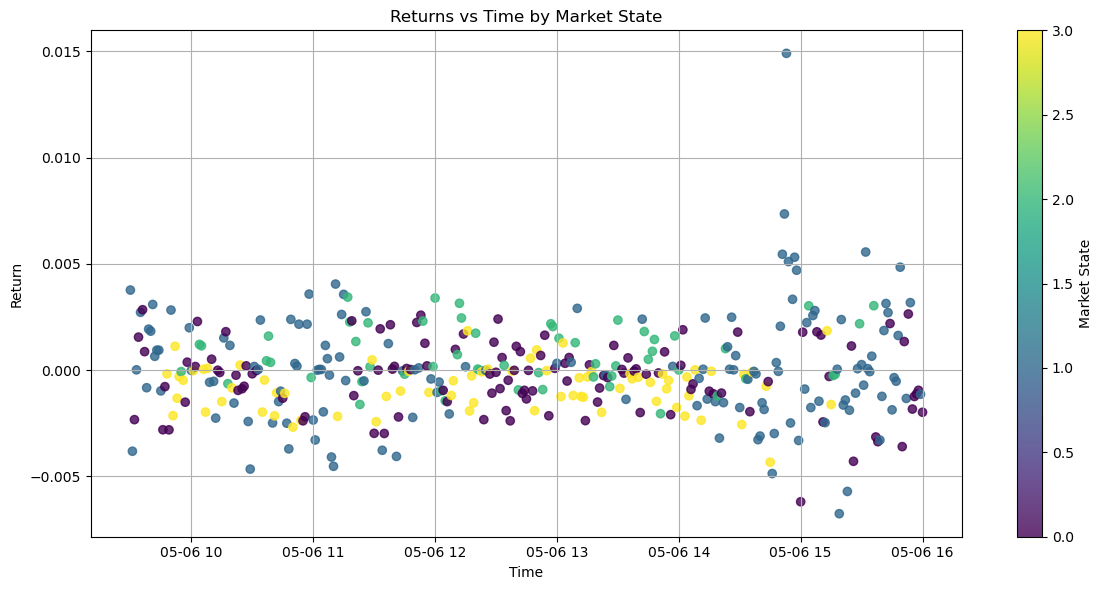

In [38]:
import matplotlib.pyplot as plt

cdf_bh = cdf[cdf['stock'] == 'C']

# Convert the 'minute' column to a datetime object for plotting
cdf_bh["minute"] = pd.to_datetime(cdf_bh["minute"])
#I want only minutes in the 6 may
cdf_bh = cdf_bh[cdf_bh["minute"].dt.date == pd.Timestamp("2010-05-06").date()]

display(cdf_bh.head())

# Plot returns vs time, color-coded by market_state
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    cdf_bh["minute"], cdf_bh["return"], c=cdf_bh["cluster"], cmap="viridis", alpha=0.8
)
plt.colorbar(scatter, label="Market State")
plt.title("Returns vs Time by Market State")
plt.xlabel("Time")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#group by last cluster of window  and display aggregated statistics
flattened_data.groupby('cluster').agg({
    'price_volatility': 'mean',
    'return_volatility': 'mean',
    'avg_return': 'mean',
    'avg_trade_volume': 'mean',
    'avg_spread': 'mean',
    'cluster': 'count'
})





,price_volatility,return_volatility,avg_return,avg_trade_volume,avg_spread,cluster
cluster,,,,,,
0,38.500319,0.000898,-0.000055,54603.290597,0.039897,1825
1,31.677841,0.002068,0.000133,213093.499019,0.048043,1575
2,29.334181,0.000758,0.000514,40960.433891,0.024184,2163
3,29.324942,0.000768,-0.000555,42915.823291,0.024208,2228



Trading Performance Metrics:
Total Trades: 2915
Total P&L: $-301,100,587.62
Win Rate: 25.66%
Average Trade P&L: $-103,293.51
Sharpe Ratio: -1.05


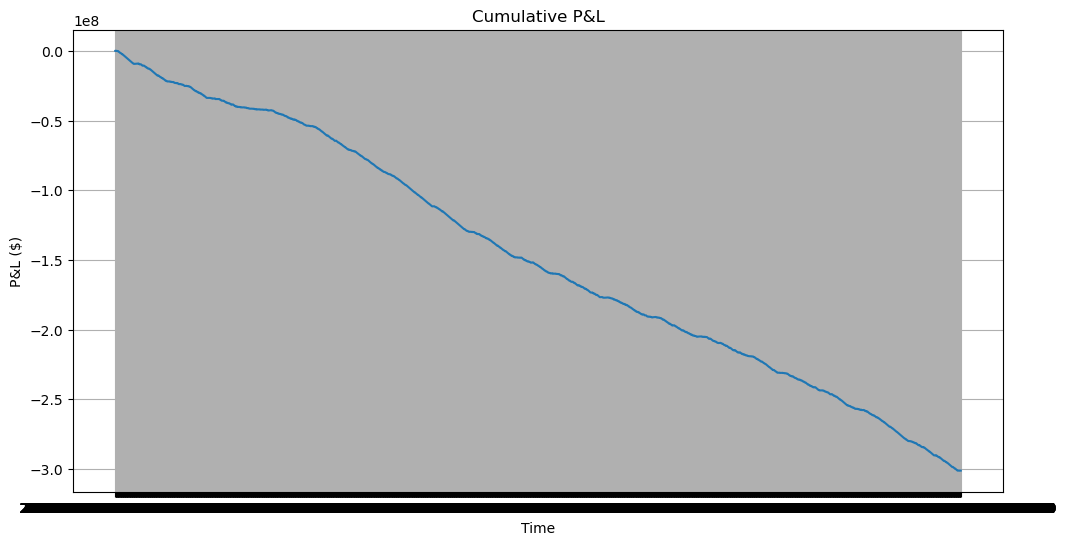

In [44]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import json

class ClusterBasedStrategy:
    def __init__(self):
        self.positions = []
        self.current_position = 0
        self.portfolio_value = 100000  # Initial capital
        
    def parse_transition_matrix(self, matrix_str: str) -> np.ndarray:
        """Parse the transition matrix string into numpy array."""
        try:
            # Clean the string and extract matrix values
            matrix_str = matrix_str.replace('...', '')
            matrix = json.loads(matrix_str)
            return np.array(matrix)
        except:
            # Return None if parsing fails
            return None

    def predict_next_state(self, current_cluster: int, transition_matrix: np.ndarray) -> int:
        """Predict the next most likely state using transition probabilities."""
        if transition_matrix is None or len(transition_matrix) <= current_cluster:
            return current_cluster
        probs = transition_matrix[current_cluster]
        return np.argmax(probs)

    def mean_reversion_strategy(self, row: pd.Series) -> Dict:
        """Strategy for Cluster 0: High volatility, mean reversion with tight stop-loss"""
        signal = {
            'action': 'HOLD',
            'size': 0,
            'reason': '',
            'stop_loss': None
        }
        
        if row.price_volatility > 35 and abs(row.avg_return) > 0.001:
            signal['action'] = 'BUY' if row.avg_return < 0 else 'SELL'
            signal['size'] = int(50000 / (row.price_volatility * row.avg_spread))
            signal['reason'] = 'Mean reversion on high volatility'
            signal['stop_loss'] = row.avg_return * 1.5  # Tight stop-loss
            
        return signal

    def volatility_breakout_strategy(self, row: pd.Series, prev_row: pd.Series) -> Dict:
        """Strategy for Cluster 1: Volatility breakout trading"""
        signal = {
            'action': 'HOLD',
            'size': 0,
            'reason': ''
        }
        
        if prev_row is not None:
            vol_ratio = row.avg_trade_volume / prev_row.avg_trade_volume
            if vol_ratio > 1.5 and row.return_volatility > 0.001:
                signal['action'] = 'BUY' if row.avg_return > 0 else 'SELL'
                base_size = int(100000 * min(1, row.return_volatility))
                volume_adj = min(1, row.avg_trade_volume / 200000)
                signal['size'] = int(base_size * volume_adj)
                signal['reason'] = 'Volatility breakout'
                
        return signal

    def trend_following_strategy(self, row: pd.Series, next_state: int) -> Dict:
        """Strategy for Cluster 2: Trend-following on predictable assets"""
        signal = {
            'action': 'HOLD',
            'size': 0,
            'reason': ''
        }
        
        if row.avg_return > 0 and row.price_volatility < 32:
            signal['action'] = 'BUY'
            base_size = int(150000 / (1 + row.avg_spread))
            # Increase position if likely to stay in trend
            signal['size'] = int(base_size * 1.2) if next_state == 2 else base_size
            signal['reason'] = 'Trend following on stable asset'
            
        return signal

    def defensive_strategy(self, row: pd.Series, next_state: int) -> Dict:
        """Strategy for Cluster 3: Defensive hedging or avoidance"""
        signal = {
            'action': 'HOLD',
            'size': 0,
            'reason': ''
        }
        
        if row.avg_return < -0.001 and row.price_volatility < 32:
            signal['action'] = 'SELL'
            base_size = int(75000 * (1 - row.avg_spread))
            # Reduce position if likely to stay in defensive state
            signal['size'] = int(base_size * 0.7) if next_state == 3 else base_size
            signal['reason'] = 'Defensive hedge'
            
        return signal

    def execute_strategy(self, data: pd.DataFrame) -> pd.DataFrame:
        """Execute the trading strategy on the dataset."""
        results = []
        
        for i in range(len(data)):
            row = data.iloc[i]
            prev_row = data.iloc[i-1] if i > 0 else None
            
            # Parse transition matrix and predict next state
            transition_matrix = self.parse_transition_matrix(row.transition_matrix)
            next_state = self.predict_next_state(row.cluster, transition_matrix)
            
            # Execute cluster-specific strategy
            if row.cluster == 0:
                signal = self.mean_reversion_strategy(row)
            elif row.cluster == 1:
                signal = self.volatility_breakout_strategy(row, prev_row)
            elif row.cluster == 2:
                signal = self.trend_following_strategy(row, next_state)
            else:  # cluster 3
                signal = self.defensive_strategy(row, next_state)
            
            # Record the trade
            if signal['action'] != 'HOLD':
                trade = {
                    'timestamp': row.minute,
                    'cluster': row.cluster,
                    'action': signal['action'],
                    'size': signal['size'],
                    'reason': signal['reason'],
                    'price_volatility': row.price_volatility,
                    'avg_trade_volume': row.avg_trade_volume,
                    'avg_spread': row.avg_spread,
                    'return_volatility': row.return_volatility,
                    'avg_return': row.avg_return
                }
                
                # Calculate P&L
                price_impact = row.avg_spread if signal['action'] == 'BUY' else -row.avg_spread
                trade['pnl'] = signal['size'] * (-1 if signal['action'] == 'BUY' else 1) * (1 + price_impact)
                
                results.append(trade)
        
        return pd.DataFrame(results)

    def backtest(self, data: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Run backtest and return results with performance metrics."""
        # Execute strategy
        trades_df = self.execute_strategy(data)
        
        # Calculate performance metrics
        metrics = {
            'total_trades': len(trades_df),
            'total_pnl': trades_df['pnl'].sum(),
            'win_rate': len(trades_df[trades_df['pnl'] > 0]) / len(trades_df),
            'avg_trade_pnl': trades_df['pnl'].mean(),
            'sharpe_ratio': trades_df['pnl'].mean() / trades_df['pnl'].std() if len(trades_df) > 0 else 0,
            'by_cluster': trades_df.groupby('cluster').agg({
                'pnl': ['count', 'sum', 'mean'],
                'size': 'mean'
            }).to_dict()
        }
        
        return trades_df, metrics

# Example usage:
if __name__ == "__main__":
    # Load your data
    df = flattened_data
    
    # Initialize and run strategy
    strategy = ClusterBasedStrategy()
    trades, metrics = strategy.backtest(df)
    
    # Print results
    print("\nTrading Performance Metrics:")
    print(f"Total Trades: {metrics['total_trades']}")
    print(f"Total P&L: ${metrics['total_pnl']:,.2f}")
    print(f"Win Rate: {metrics['win_rate']:.2%}")
    print(f"Average Trade P&L: ${metrics['avg_trade_pnl']:,.2f}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    
    # Plot results using your preferred visualization library
    # Example with matplotlib:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.plot(trades['timestamp'], trades['pnl'].cumsum())
    plt.title('Cumulative P&L')
    plt.xlabel('Time')
    plt.ylabel('P&L ($)')
    plt.grid(True)
    plt.show()

In [123]:
# Function to adjust transition matrices and set out-of-range values to 0
# Also handles cases where rows are very close to zero (within a small threshold)
# Function to adjust transition matrices with additional correction
def adjust_and_normalize_rows(matrix, cluster, threshold=1e-6):
    matrix = np.array(matrix)
    #replace nan values with 0
    matrix = np.nan_to_num(matrix, nan=0)
    
    # Set values >1 or <0 to 0
    matrix[(matrix > 1) | (matrix < 0)] = 0
    # Correct rows with all zeros or nearly zero
    for row_index in range(matrix.shape[0]):
        if np.all(np.abs(matrix[row_index]) < threshold):  # If row is nearly zero
            matrix[row_index, :] = 0
            matrix[row_index, row_index] = 1  # Set diagonal element to 1
        else:
            # Check if all elements are the same (or nearly same considering threshold)
            if np.all(np.abs(matrix[row_index] - matrix[row_index][0]) < threshold):
                row_sum = np.sum(matrix[row_index])
                if row_sum > 0:  # Avoid division by zero
                    matrix[row_index] /= row_sum  # Normalize row to sum to 1
    return matrix.tolist()



# Apply the function to each row in the DataFrame
flattened_data['transition_matrix'] = flattened_data.apply(
    lambda row: adjust_and_normalize_rows(row['transition_matrix'], row['cluster']), axis=1
)





In [126]:
# Apply the function to each row in the DataFrame
flattened_data['transition_matrix'] = flattened_data.apply(
    lambda row: adjust_and_normalize_rows(row['transition_matrix'], row['cluster']), axis=1
)

In [133]:
#check where the transition matrix rows do not sum to 1
def check_transition_matrix(matrix):
    matrix = np.array(matrix)
    row_sums = matrix.sum(axis=1)
    return not np.allclose(row_sums, 1.0)

data = flattened_data.copy()

# Apply the check to each row and store the result in a new column
data['invalid_transition_matrix'] = data['transition_matrix'].apply(check_transition_matrix)

# Filter rows with invalid transition matrices
rows_with_invalid = data[data['invalid_transition_matrix']]

# Display rows with invalid transition matrices, if any

In [139]:
# Define the trading strategy function

data = flattened_data.copy()
starting_price = 100  # Initial price

# Add a column named 'proxy_price' based on the price evolution from returns
data['proxy_price'] = starting_price * (1 + flattened_data['avg_return']).cumprod()
def trading_strategy(row):
    cluster = row['cluster']
    avg_return = row['avg_return']
    
    if cluster == 0:  # Mean Reversion
        return 'Buy' if avg_return < 0 else 'Sell'
    elif cluster == 1:  # Volatility Breakout
        return 'Buy' if avg_return > 0 else 'Hold'
    elif cluster == 2:  # Trend Following
        return 'Buy' if avg_return > 0 else 'Sell'
    elif cluster == 3:  # Defensive Hedging
        return 'Sell'
    else:
        return 'Hold'

# Apply the trading strategy to the DataFrame
data['strategy_action'] = data.apply(trading_strategy, axis=1)

# Simulate the portfolio
initial_balance = 100000  # Starting capital
balance = initial_balance
positions = 0  # Number of units held
trade_log = []

for _, row in data.iterrows():
    action = row['strategy_action']
    price = row['proxy_price']  # Use trade volume as a proxy for price
    
    if action == 'Buy' and balance > 0:
        positions += balance / price  # Buy as much as possible
        trade_log.append({'minute': row['minute'], 'action': 'Buy', 'price': price, 'positions': positions})
        balance = 0
    elif action == 'Sell' and positions > 0:
        balance += positions * price  # Sell all positions
        trade_log.append({'minute': row['minute'], 'action': 'Sell', 'price': price, 'balance': balance})
        positions = 0

final_balance = balance + (positions * data.iloc[-1]['avg_trade_volume'])

print(f"Final Portfolio Balance: ${final_balance:.2f}")


Final Portfolio Balance: $138198.60


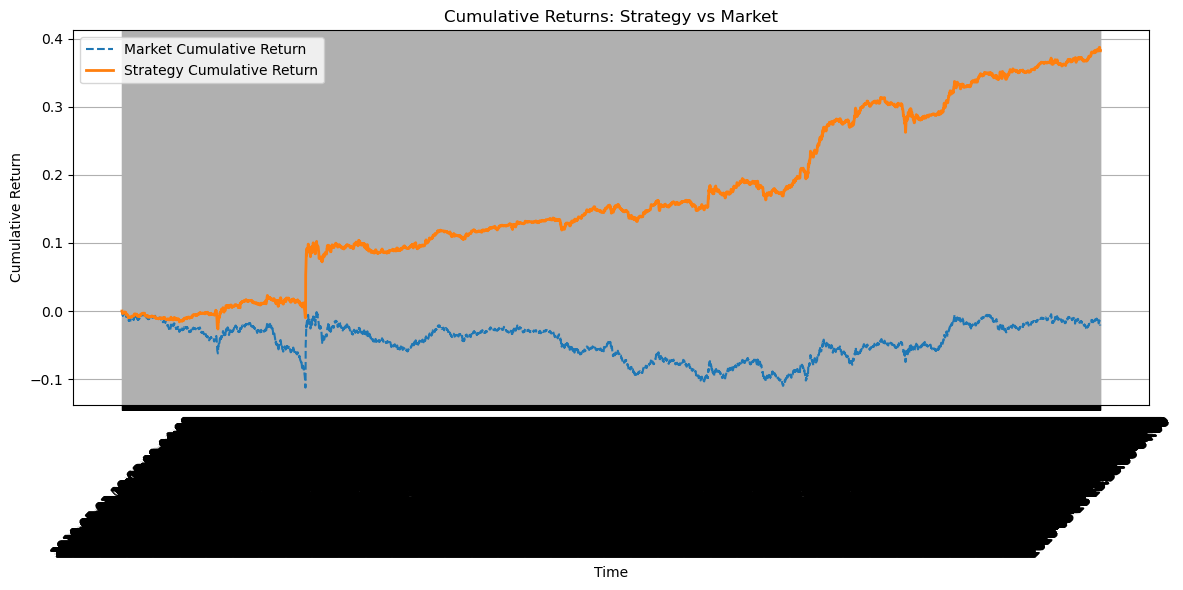

In [141]:
# Initialize cumulative returns tracking
data['market_cumulative_return'] = data['proxy_price'] / starting_price - 1

# Initialize portfolio simulation parameters
cumulative_returns = []  # To track cumulative returns of the strategy
balance = initial_balance
positions = 0  # Number of units held

# Simulate the portfolio
for _, row in data.iterrows():
    action = row['strategy_action']
    price = row['proxy_price']

    if action == 'Buy' and balance > 0:
        positions += balance / price  # Buy as much as possible
        balance = 0
    elif action == 'Sell' and positions > 0:
        balance += positions * price  # Sell all positions
        positions = 0

    # Portfolio value at each time step
    portfolio_value = balance + (positions * price)
    cumulative_returns.append((portfolio_value / initial_balance) - 1)

# Add strategy cumulative returns to the DataFrame
data['strategy_cumulative_return'] = cumulative_returns

# Plot cumulative returns for both market and strategy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['minute'], data['market_cumulative_return'], label="Market Cumulative Return", linestyle='--')
plt.plot(data['minute'], data['strategy_cumulative_return'], label="Strategy Cumulative Return", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Returns: Strategy vs Market")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [143]:
#save flattened_data as final_df
flattened_data.to_csv('final_df.csv')